# Replicative validation notebook

In this notebook, the figure is generated that is used for the replicative validation in chapter 3.4.3. In the figure, the model outcomes of Neodymium demand are compared to projections of future Neodymium demand from related scientific research.

This notebook is built up in the following way:
1. Some libraries are imported.
2. Functions are defined that will be used later.
3. The model outcomes from this research will be put into a format that is easy to work with.
4. A dataset will be generated from the projections from related research. This will be done by interpolating points and creating a new dataset.
5. The datasets are combined.
6. The figure will be generated. 

## 1. Import functions

In [1]:
from __future__ import (absolute_import, print_function, division, unicode_literals)
from ema_workbench import (Model, RealParameter, CategoricalParameter, ScalarOutcome, Constant,\
                           Policy, perform_experiments, ema_logging, \
                           TimeSeriesOutcome, perform_experiments,save_results, load_results)
#from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis import (clusterer, plotting, Density, pairs_plotting, get_ex_feature_scores, \
                                    RuleInductionType, feature_scoring)
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis.plotting_util import do_titles,do_ylabels, TIME
import ema_workbench.analysis.plotting_util as plt_util
from ema_workbench.analysis.plotting import group_by_envelopes, single_envelope, plot_lines_with_envelopes, prepare_data 
from ema_workbench.analysis.plotting import simple_kde, group_density, plot_envelope, simple_density
from ema_workbench.analysis.plotting import lines, envelopes, kde_over_time, multiple_densities
from ema_workbench.analysis.pairs_plotting import pairs_scatter, pairs_density
import ema_workbench.analysis.cart as cart
from ema_workbench.analysis.pairs_plotting import (pairs_lines, pairs_scatter,pairs_density)
import numpy as np
import seaborn as sns #; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
TIME_LABEL = 'Time'

import importlib
importlib.reload(sdutil)
importlib.reload(cart)

import itertools
import datetime
import math
import matplotlib.gridspec as gridspec
import scipy.stats.kde as kde
from matplotlib.colors import ColorConverter
from matplotlib.collections import PolyCollection, PathCollection
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from matplotlib.patches import ConnectionPatch
import matplotlib.font_manager as fm
import matplotlib as mpl

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. I

## 2. Defining functions

In [2]:
def save_fig(fig, dir, name, dpi=300):
    '''save a high res and a low res version of the figure in the specified
    directory, using the label i.
    Parameters
    ----------
    fig : a Figure instance
    dir : str
    the directory where figures are to be saved
    name : str
    dpi : int, optional
    '''
    fig.savefig('{}/fig_{}_{}dpi.png'.format(dir, name, dpi), dpi=dpi,
    bbox_inches='tight', format='png')

In [3]:
def change_fontsize(fig, fs=11.5):
    '''Change fontsize of figure items to specified size'''
    for ax in fig.axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fs)
        try:
            parasites = ax.parasites
        except AttributeError:
            pass
        else:
            for parisite in parasites:
                for axis in parisite.axis.values():
                    axis.major_ticklabels.set_fontsize(fs)
                    axis.label.set_fontsize(fs)
            for axis in ax.axis.values():
                axis.major_ticklabels.set_fontsize(fs)
                axis.label.set_fontsize(fs)
        if ax.legend_ != None:
            for entry in ax.legend_.get_texts():
                entry.set_fontsize(fs)
        for entry in ax.texts:
            entry.set_fontsize(fs)
        for entry in ax.tables:
            entry.set_fontsize(fs)

In [4]:
def nice_lines (exp,out,out_to_show,
                group_by= None,
                density=None,title=None,
                exp_to_show = None,
                grouping_specifiers = None,
                legend = False,
                convert_to_t = False,
                convert_to_kt = False,
                convert_to_Mt = False,
                zero = False ,
                yupperlim = None,
                ylabel = False,
                alpha = None,
                sizex = None,
                sizey = None):
    
    if convert_to_kt == True:
        out[title] = out[out_to_show]/1000000
        lines(experiments = exp, outcomes = out,
            experiments_to_show = exp_to_show,
            outcomes_to_show = title, legend = legend,
            group_by = group_by, density = density,
            grouping_specifiers = grouping_specifiers)
    else:
        out[title] = out[out_to_show]
        lines(experiments = exp, outcomes = out, experiments_to_show = exp_to_show, outcomes_to_show = title,legend = legend, group_by = group_by, density = density, grouping_specifiers = grouping_specifiers)
    
    fig = plt.gcf()
    fig.set_size_inches(6,3)
    
    if sizex:
        fig.set_size_inches(sizex,sizey)
    ax = fig.get_axes()
    
    if zero == True:
        ax[0].set_ylim([0,yupperlim])
    ax[0].set_xticklabels(labels_time)
    
    if ylabel:
        ax[0].set(ylabel=ylabel)
    
    if alpha:
        for line in ax[0].get_lines():
            line.set_alpha(alpha)
    short_title = title.replace(" ","")
    change_fontsize(fig)
    sns.despine()
 #   save_fig(fig,wd,short_title)
# fig.savefig(wd+paradigm+short_title+'.jpg')
    plt.show()

In [5]:
labels_time = [2000, 2010, 2020, 2030, 2040, 2050]
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['legend.frameon'] = False

## 3. Make dataframe from model outcomes

In [6]:
results = load_results('Results/Model_runs.tar.gz')
experiments, outcomes = results

In [9]:
df_dem_nd = pd.DataFrame(outcomes["Total demand REE[Neodymium]"])

In [10]:
df_dem_nd.columns = outcomes["Time"][0]

In [11]:
df_dem_nd

,2000.00,2000.25,2000.50,2000.75,2001.00,2001.25,2001.50,2001.75,2002.00,2002.25,...,2047.75,2048.00,2048.25,2048.50,2048.75,2049.00,2049.25,2049.50,2049.75,2050.00
0,25282746.0,25288824.0,25259974.0,25223738.0,25193998.0,25175092.0,25171760.0,25184962.0,25213558.0,25255088.0,...,72421680.0,72736856.0,73071210.0,73424870.0,73797860.0,74190100.0,74601470.0,75031840.0,75481090.0,75949150.0
1,26617858.0,26603698.0,26530892.0,26444226.0,26370356.0,26319128.0,26293202.0,26293752.0,26317250.0,26358778.0,...,95288230.0,95018584.0,94734670.0,94448456.0,89024650.0,88125940.0,87281464.0,85598550.0,84529810.0,83451150.0
2,25806982.0,25788974.0,25696860.0,25558960.0,25412084.0,25280490.0,25178814.0,25113790.0,25085146.0,25088870.0,...,99117960.0,99742550.0,100382264.0,101038010.0,101711544.0,102405360.0,103122420.0,103865990.0,104639416.0,105445944.0
3,25644064.0,25643260.0,25607664.0,25544120.0,25463722.0,25380102.0,25302898.0,25239594.0,25195176.0,25171560.0,...,79257576.0,78644680.0,78175690.0,77859960.0,77699320.0,77690510.0,77826940.0,78099730.0,78499170.0,79015570.0
4,26042850.0,26044264.0,26014606.0,25965812.0,25911138.0,25860044.0,25818860.0,25790360.0,25775020.0,25772756.0,...,79469360.0,79961224.0,80447656.0,80926660.0,81396700.0,81856900.0,82307070.0,82747860.0,83180590.0,83607230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,26751640.0,26756626.0,26745984.0,26733884.0,26731584.0,26743058.0,26770698.0,26814916.0,26874736.0,26947800.0,...,87196480.0,87726776.0,88266430.0,88812920.0,89363280.0,89914584.0,90464560.0,91012040.0,91557090.0,92100900.0
4996,26343850.0,26313114.0,26209468.0,26073356.0,25940834.0,25830428.0,25750724.0,25703282.0,25685098.0,25689754.0,...,85478184.0,86211976.0,86966920.0,87739360.0,88525190.0,89320120.0,90119880.0,90920430.0,91718100.0,92509680.0
4997,26963182.0,26963820.0,26917446.0,26838820.0,26739200.0,26629324.0,26515826.0,26408586.0,26312658.0,26229800.0,...,93636350.0,94054390.0,94491150.0,94949050.0,95430410.0,95937410.0,96472120.0,97036430.0,97631980.0,98260160.0
4998,25395564.0,25394846.0,25364188.0,25324312.0,25291754.0,25273876.0,25273572.0,25291304.0,25325688.0,25373006.0,...,93603576.0,94368140.0,95175650.0,96026160.0,96919560.0,97855520.0,98833470.0,99852640.0,100912090.0,102010730.0


In [12]:
#From kg to kt
df_dem_nd = df_dem_nd / 1000000

## 4. Make a dataframe with predictions from literature

In [13]:
from scipy.interpolate import interp1d

In [14]:
# I have a few datapoints from predictions from the literature. 
# To create a consistent dataset with the others, I'm interpolating data
def interpolate_post(lists,i):
    x = np.linspace(0,1,41)
    y = ( (lists[i+1] - lists[i]) * x ) + lists[i]
    f = interp1d(x,y)
    xnew = np.linspace(0,1,41)
    ynew = f(xnew)
    return ynew

In [15]:
# The datapoints from the predictions from literature
watari_low_bound = [30,50,60,70]
watari_up_bound = [80,200,230,260]
roelich = [40,75,145,210]
baseline = [35,48,70,100]
map_ = [35,75,100,130]
hi_ren = [35,55,90,160]
hun_ren = [35,65,120,240]

In [16]:
twenties_data = [interpolate_post(watari_low_bound,0), interpolate_post(watari_up_bound,0), interpolate_post(roelich,0),
                 interpolate_post(baseline,0), interpolate_post(map_,0), interpolate_post(hi_ren,0), 
                 interpolate_post(hun_ren,0)]
df_twenties = pd.DataFrame(twenties_data)

In [17]:
thirties_data = [interpolate_post(watari_low_bound,1), interpolate_post(watari_up_bound,1), interpolate_post(roelich,1),
                 interpolate_post(baseline,1), interpolate_post(map_,1), interpolate_post(hi_ren,1), interpolate_post(hun_ren,1)]
df_thirties = pd.DataFrame(thirties_data)
df_thirties = df_thirties.drop(df_thirties.columns[[0,-1]],axis=1)

In [18]:
fourties_data = [interpolate_post(watari_low_bound,2), interpolate_post(watari_up_bound,2), interpolate_post(roelich,2),
                 interpolate_post(baseline,2), interpolate_post(map_,2), interpolate_post(hi_ren,2), interpolate_post(hun_ren,2)]
df_fourties = pd.DataFrame(fourties_data)

In [19]:
# Adjusted the function from before to interpolate data over twenty years instead of 10. 
# I picked 24, because it seemed like this was an average starting value in the outcome dataset
def interpolate_prior(lists):
    x = np.linspace(0,1,81)
    y = ( (lists[0] - 24) * x ) + 24
    f = interp1d(x,y)
    xnew = np.linspace(0,1,81)
    ynew = f(xnew)
    return ynew

In [20]:
zeros_to_twenty_data = [interpolate_prior(watari_low_bound), interpolate_prior(watari_up_bound), interpolate_prior(roelich),
                 interpolate_prior(baseline), interpolate_prior(map_), interpolate_prior(hi_ren), interpolate_prior(hun_ren)]
df_zeros_to_twenty = pd.DataFrame(zeros_to_twenty_data)
df_zeros_to_twenty = df_zeros_to_twenty.drop(df_zeros_to_twenty.columns[-1],axis=1)

In [21]:
df_zeros_to_twenty

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,24.0,24.0750,24.150,24.2250,24.30,24.3750,24.450,24.5250,24.6,24.6750,...,29.250,29.3250,29.4,29.4750,29.550,29.6250,29.70,29.7750,29.850,29.9250
1,24.0,24.7000,25.400,26.1000,26.80,27.5000,28.200,28.9000,29.6,30.3000,...,73.000,73.7000,74.4,75.1000,75.800,76.5000,77.20,77.9000,78.600,79.3000
2,24.0,24.2000,24.400,24.6000,24.80,25.0000,25.200,25.4000,25.6,25.8000,...,38.000,38.2000,38.4,38.6000,38.800,39.0000,39.20,39.4000,39.600,39.8000
3,24.0,24.1375,24.275,24.4125,24.55,24.6875,24.825,24.9625,25.1,25.2375,...,33.625,33.7625,33.9,34.0375,34.175,34.3125,34.45,34.5875,34.725,34.8625
4,24.0,24.1375,24.275,24.4125,24.55,24.6875,24.825,24.9625,25.1,25.2375,...,33.625,33.7625,33.9,34.0375,34.175,34.3125,34.45,34.5875,34.725,34.8625
5,24.0,24.1375,24.275,24.4125,24.55,24.6875,24.825,24.9625,25.1,25.2375,...,33.625,33.7625,33.9,34.0375,34.175,34.3125,34.45,34.5875,34.725,34.8625
6,24.0,24.1375,24.275,24.4125,24.55,24.6875,24.825,24.9625,25.1,25.2375,...,33.625,33.7625,33.9,34.0375,34.175,34.3125,34.45,34.5875,34.725,34.8625


In [22]:
df_articles = pd.concat([df_zeros_to_twenty,df_twenties, df_thirties, df_fourties], axis=1)
df_articles.columns = outcomes["Time"][0]
df_articles

,2000.00,2000.25,2000.50,2000.75,2001.00,2001.25,2001.50,2001.75,2002.00,2002.25,...,2047.75,2048.00,2048.25,2048.50,2048.75,2049.00,2049.25,2049.50,2049.75,2050.00
0,24.0,24.0750,24.150,24.2250,24.30,24.3750,24.450,24.5250,24.6,24.6750,...,67.750,68.0,68.250,68.50,68.750,69.0,69.250,69.50,69.750,70.0
1,24.0,24.7000,25.400,26.1000,26.80,27.5000,28.200,28.9000,29.6,30.3000,...,253.250,254.0,254.750,255.50,256.250,257.0,257.750,258.50,259.250,260.0
2,24.0,24.2000,24.400,24.6000,24.80,25.0000,25.200,25.4000,25.6,25.8000,...,195.375,197.0,198.625,200.25,201.875,203.5,205.125,206.75,208.375,210.0
3,24.0,24.1375,24.275,24.4125,24.55,24.6875,24.825,24.9625,25.1,25.2375,...,93.250,94.0,94.750,95.50,96.250,97.0,97.750,98.50,99.250,100.0
4,24.0,24.1375,24.275,24.4125,24.55,24.6875,24.825,24.9625,25.1,25.2375,...,123.250,124.0,124.750,125.50,126.250,127.0,127.750,128.50,129.250,130.0
5,24.0,24.1375,24.275,24.4125,24.55,24.6875,24.825,24.9625,25.1,25.2375,...,144.250,146.0,147.750,149.50,151.250,153.0,154.750,156.50,158.250,160.0
6,24.0,24.1375,24.275,24.4125,24.55,24.6875,24.825,24.9625,25.1,25.2375,...,213.000,216.0,219.000,222.00,225.000,228.0,231.000,234.00,237.000,240.0


## 5. Combine the datasets

In [23]:
df_all = pd.concat([df_dem_nd,df_articles], axis=0)
df_all

,2000.00,2000.25,2000.50,2000.75,2001.00,2001.25,2001.50,2001.75,2002.00,2002.25,...,2047.75,2048.00,2048.25,2048.50,2048.75,2049.00,2049.25,2049.50,2049.75,2050.00
0,25.282746,25.288824,25.259974,25.223738,25.193998,25.175092,25.171760,25.184962,25.213558,25.255088,...,72.421680,72.736856,73.071210,73.424870,73.797860,74.19010,74.601470,75.03184,75.481090,75.949150
1,26.617858,26.603698,26.530892,26.444226,26.370356,26.319128,26.293202,26.293752,26.317250,26.358778,...,95.288230,95.018584,94.734670,94.448456,89.024650,88.12594,87.281464,85.59855,84.529810,83.451150
2,25.806982,25.788974,25.696860,25.558960,25.412084,25.280490,25.178814,25.113790,25.085146,25.088870,...,99.117960,99.742550,100.382264,101.038010,101.711544,102.40536,103.122420,103.86599,104.639416,105.445944
3,25.644064,25.643260,25.607664,25.544120,25.463722,25.380102,25.302898,25.239594,25.195176,25.171560,...,79.257576,78.644680,78.175690,77.859960,77.699320,77.69051,77.826940,78.09973,78.499170,79.015570
4,26.042850,26.044264,26.014606,25.965812,25.911138,25.860044,25.818860,25.790360,25.775020,25.772756,...,79.469360,79.961224,80.447656,80.926660,81.396700,81.85690,82.307070,82.74786,83.180590,83.607230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,24.000000,24.200000,24.400000,24.600000,24.800000,25.000000,25.200000,25.400000,25.600000,25.800000,...,195.375000,197.000000,198.625000,200.250000,201.875000,203.50000,205.125000,206.75000,208.375000,210.000000
3,24.000000,24.137500,24.275000,24.412500,24.550000,24.687500,24.825000,24.962500,25.100000,25.237500,...,93.250000,94.000000,94.750000,95.500000,96.250000,97.00000,97.750000,98.50000,99.250000,100.000000
4,24.000000,24.137500,24.275000,24.412500,24.550000,24.687500,24.825000,24.962500,25.100000,25.237500,...,123.250000,124.000000,124.750000,125.500000,126.250000,127.00000,127.750000,128.50000,129.250000,130.000000
5,24.000000,24.137500,24.275000,24.412500,24.550000,24.687500,24.825000,24.962500,25.100000,25.237500,...,144.250000,146.000000,147.750000,149.500000,151.250000,153.00000,154.750000,156.50000,158.250000,160.000000


In [24]:
# I need an experiments set that is as long as the outcomes. 
# The values are irrelevant for this purpose, because we're only comparing outcomes
experiments_ext = pd.concat([experiments, experiments.iloc[0:7]], axis=0)
experiments_ext

,"""High coercive magnet-for-magnet substitution threshold""","""Low coercive magnet-for-magnet substitution threshold""",Decay factor,Fraction extra production costs for a lower magnet content,Long term substitution strength,Maximum decrease production capacity,Maximum increase production capacity,Minimum price of illegal mining,Minimum stock transit time,Price elasticity long term,...,Uncertainty factor weight NdFeB in application,scenario,policy,model,EV clusters,Wind clusters,Nd clusters,Dy clusters,Dy clusters2,Wind clusters2
0,3.261819,1.642010,0.028017,0.234868,0.102244,0.027851,0.182599,3.560991,0.122805,0.146859,...,0.963326,0,None,Vensim,Low,Medium,Medium,Low,Low,Medium
1,3.350830,1.664209,0.032976,0.419508,0.119559,0.045650,0.129152,2.253508,0.064630,0.126500,...,1.038896,1,None,Vensim,Medium,Medium,Medium,Low,Low,Medium
2,2.137131,1.996489,0.018971,0.280364,0.138637,0.035913,0.158071,1.178035,0.236135,0.134432,...,1.220167,2,None,Vensim,Low,Medium,Medium,Low,Low,Medium
3,2.663433,2.278588,0.011171,0.262410,0.098572,0.032960,0.108468,1.790418,0.248238,0.137132,...,1.194943,3,None,Vensim,High,Medium,Medium,Low,Low,Medium
4,2.018154,2.107906,0.019719,0.348806,0.086463,0.020340,0.167913,2.440091,0.232877,0.135055,...,0.761526,4,None,Vensim,Medium,Medium,Medium,Low,Low,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2.137131,1.996489,0.018971,0.280364,0.138637,0.035913,0.158071,1.178035,0.236135,0.134432,...,1.220167,2,None,Vensim,Low,Medium,Medium,Low,Low,Medium
3,2.663433,2.278588,0.011171,0.262410,0.098572,0.032960,0.108468,1.790418,0.248238,0.137132,...,1.194943,3,None,Vensim,High,Medium,Medium,Low,Low,Medium
4,2.018154,2.107906,0.019719,0.348806,0.086463,0.020340,0.167913,2.440091,0.232877,0.135055,...,0.761526,4,None,Vensim,Medium,Medium,Medium,Low,Low,Medium
5,3.288494,2.077545,0.034758,0.295685,0.193573,0.035776,0.102065,3.388264,0.117138,0.119194,...,0.717691,5,None,Vensim,Low,Medium,Medium,Low,Low,Medium


In [25]:
outcomes_ext = outcomes
outcomes_ext["Nd demand"] = df_all.to_numpy()

In [26]:
experiments_ext["rows"] = 0
experiments_ext["rows"][-1] = 1
experiments_ext["rows"][-2] = 2
experiments_ext["rows"][-3] = 3
experiments_ext["rows"][-4] = 4
experiments_ext["rows"][-5] = 5
experiments_ext["rows"][-6] = 6
experiments_ext["rows"][-7] = 7

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the 

## 6. Making figure

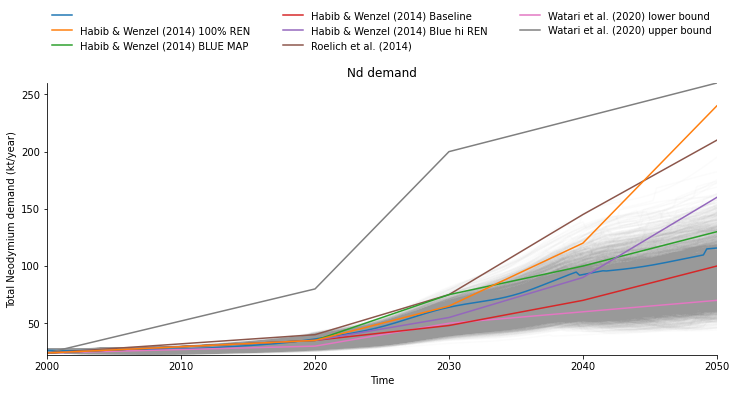

In [27]:
lines(experiments_ext, outcomes_ext, 'Nd demand',group_by = 'rows' , legend = True ,
grouping_specifiers= {'Habib & Wenzel (2014) 100% REN': 1, 'Habib & Wenzel (2014) Blue hi REN':2, "Watari et al. (2020) lower bound" : 7,
                      'Habib & Wenzel (2014) BLUE MAP': 3,'Habib & Wenzel (2014) Baseline':4, "Roelich et al. (2014)" : 5,
                     "Watari et al. (2020) upper bound" : 6,  '':0} )
fig = plt.gcf()
ax = fig.get_axes()
fig.set_size_inches(12,5)
#find_colors(ax[0])
number = 0
for line in ax[0].get_lines():
    number += 1
    if number < 5000:
        line.set_color((0.6,0.6,0.6))
        line.set_alpha(0.03)
    #if number == 5000:
    #    line.set_color('tab:pink')
    #    line.set_alpha(1)
    #    line.set_linewidth(1)
    if number == 5001:
        line.set_color('tab:pink')
        line.set_alpha(1)
        line.set_linewidth(1.5)
    if number == 5002:
        line.set_color('tab:gray')
        line.set_alpha(1)
        line.set_linewidth(1.5)
    if number == 5003:
        line.set_color('tab:brown')
        line.set_alpha(1)
        line.set_linewidth(1.5)
    if number == 5004:
        line.set_color('tab:red')
        line.set_alpha(1)
        line.set_linewidth(1.5)
    if number == 5005:
        line.set_color('tab:green')
        line.set_alpha(1)
        line.set_linewidth(1.5)
    if number == 5006:
        line.set_color('tab:purple')
        line.set_alpha(1)
        line.set_linewidth(1.5)
    if number == 5007:
        line.set_color('tab:orange')
        line.set_alpha(1)
        line.set_linewidth(1.5)
ax[0].set_ylabel('Total Neodymium demand (kt/year)')
sns.despine()
